In [1]:
from Exp3_VAE_utils import *

In [2]:
# Start saving checkpoints after epoch 2000
NUM_EPOCHS = 5
NUM_FOLDS = 1
DATA_PATH = "data"
CHECKPOINT_PATH = "checkpoints"

In [3]:
data_dir = DATA_PATH
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad((8, 8), fill=0, padding_mode='constant'),
])
dataset = BraTS2020Dataset(data_dir, train=True, healthy=True, transform=data_transforms)

checkpoint_ranges = []
for fold_idx in range(NUM_FOLDS):
    checkpoint_ranges.append((0, NUM_EPOCHS))

Using device: cuda
Loading train healthy data from healthy_train_images.npy
Loading data from: data/train/healthy_train_images.npy
Loaded train data with shape: (1355, 240, 240, 3)


In [4]:
config = {
    'input_size': 256,
    'first_ch': 32,
    'latent_channels': 20,
    'conv1': {'kernel_size': 2, 'stride': 2, 'padding': 0}, # 256 -> 128
    'conv2': {'kernel_size': 2, 'stride': 2, 'padding': 0}, # 128 -> 64
    'conv3': {'kernel_size': 4, 'stride': 2, 'padding': 1}, # 64 -> 32
    'conv4': {'kernel_size': 4, 'stride': 2, 'padding': 1}, # 32 -> 16
    'conv5': {'kernel_size': 4, 'stride': 2, 'padding': 1}, # 16 -> 8
    'deconv1': {'kernel_size': 4, 'stride': 2, 'padding': 1}, # 8 -> 16
    'deconv2': {'kernel_size': 4, 'stride': 2, 'padding': 1}, # 16 -> 32
    'deconv3': {'kernel_size': 4, 'stride': 2, 'padding': 1}, # 32 -> 64
    'deconv4': {'kernel_size': 4, 'stride': 2, 'padding': 1}, # 64 -> 128
    'deconv5': {'kernel_size': 2, 'stride': 2, 'padding': 0}, # 128 -> 256
    'out': {'kernel_size': 3, 'stride': 1, 'padding': 1}, # 256 -> 256
}
model = Exp3VariationalAutoEncoder(config)
del model

Model initialized with the following configuration:
Conv1 output size: 128
Conv2 output size: 64
Conv3 output size: 32
Conv4 output size: 16
Conv5 output size: 8
FC input size: 8192
Model initialized with the following configuration:
Deconv1 output size: 16
Deconv2 output size: 32
Deconv3 output size: 64
Deconv4 output size: 128
Deconv5 output size: 256
Model initialized with 834194 (0.83M) parameters


In [5]:
train_qr_vae_incremental_kfold(
    device, 
    config,
    dataset,
    epochs=NUM_EPOCHS, 
    train_batch_size=32,
    val_batch_size=271,
    k_fold = NUM_FOLDS,
    lr=3e-4,
    save_checkpoint=True, 
    checkpoint_dic_path=CHECKPOINT_PATH, 
    checkpoint_ranges=checkpoint_ranges, 
    checkpoint_interval=1,
    single_transfer=False,
    mixed_precision=True,
)

Model initialized with the following configuration:
Conv1 output size: 128
Conv2 output size: 64
Conv3 output size: 32
Conv4 output size: 16
Conv5 output size: 8
FC input size: 8192
Model initialized with the following configuration:
Deconv1 output size: 16
Deconv2 output size: 32
Deconv3 output size: 64
Deconv4 output size: 128
Deconv5 output size: 256
Model initialized with 834194 (0.83M) parameters
Mixed precision training enabled.
Training started.


100%|██████████| 5/5 [00:11<00:00,  2.39s/it, best_val_loss=49440.4945, train_loss=56584.4308, val_loss=49440.4945]   

Training completed.


Fold 0 Best Validation Loss: 65329.7048 at Epoch 3


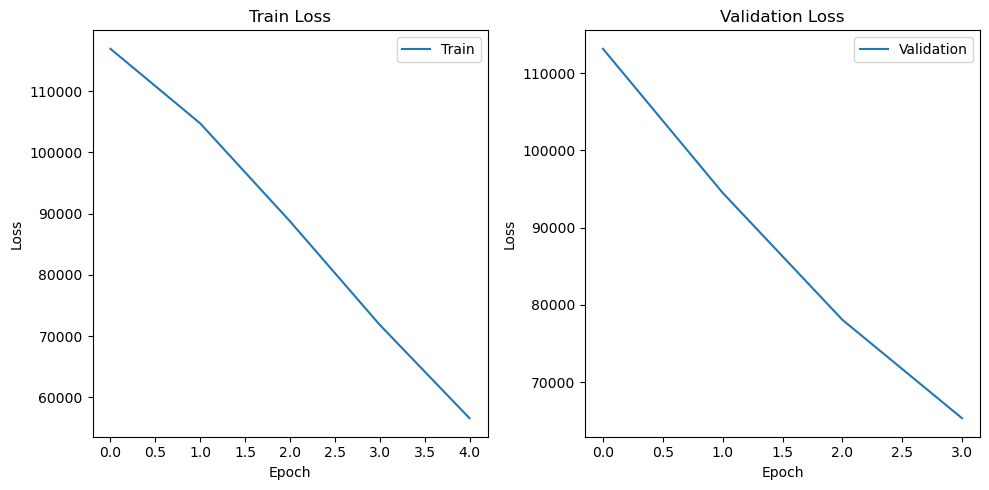

In [6]:
load_and_plot_losses(0, NUM_EPOCHS, checkpoint_dic_path=CHECKPOINT_PATH, k_fold=NUM_FOLDS)

Loading test healthy data from healthy_test_images.npy
Loading data from: data/test/healthy_test_images.npy
Loaded test data with shape: (245, 240, 240, 3)
Model initialized with the following configuration:
Conv1 output size: 128
Conv2 output size: 64
Conv3 output size: 32
Conv4 output size: 16
Conv5 output size: 8
FC input size: 8192
Model initialized with the following configuration:
Deconv1 output size: 16
Deconv2 output size: 32
Deconv3 output size: 64
Deconv4 output size: 128
Deconv5 output size: 256
Model initialized with 834194 (0.83M) parameters


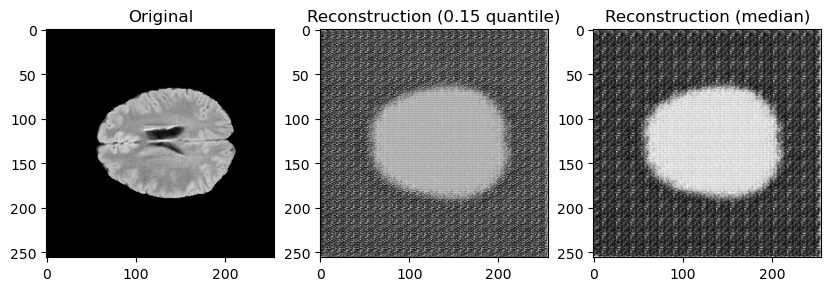

In [7]:
checkpoint_path_idx = 0
test_data_loader = load_dataset(data_dir, BraTS2020Dataset, train=False, healthy=True, batch_size=1)
sample = next(iter(test_data_loader))
for checkpoint_path_idx in range(NUM_FOLDS):
    checkpoint_path = CHECKPOINT_PATH + f'/fold_{checkpoint_path_idx}/checkpoint.pt'

    # Load the best model
    checkpoint = torch.load(checkpoint_path)
    model = Exp3VariationalAutoEncoder(config).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    ("Model loaded from checkpoint.")

    # Test the model on one picture
    model.eval()
    with torch.no_grad():
        test_data = sample['image'].to(device)
        (q1, q2), mu, logvar = model(test_data)
        # Plot the original image
        plt.figure(figsize=(10, 6))
        plt.subplot(1, 3, 1)
        plt.title("Original")
        # show the first channel of the image
        first_channel = test_data.cpu().numpy().squeeze()[0]
        plt.imshow(first_channel, cmap='gray')
        # Plot the reconstructed image
        plt.subplot(1, 3, 2)
        plt.title("Reconstruction (0.15 quantile)")
        first_channel = q1.cpu().numpy().squeeze()[0]
        plt.imshow(first_channel, cmap='gray')
        # Plot the reconstructed image
        plt.subplot(1, 3, 3)
        plt.title("Reconstruction (median)")
        first_channel = q2.cpu().numpy().squeeze()[0]
        plt.imshow(first_channel, cmap='gray')
        plt.show()


In [8]:
def test_qr_vae(device, model, test_loader, output_size=(256, 256), healthy=True, threshold=0.05):
    model.eval()
    rejection_rates = []
    true_positives, actual_positives = 0, 0  # Initialize counters for unhealthy mode
    false_positive, actual_negatives = 0, 0  # Initialize counters for healthy mode

    # Iterate through the test data
    for data in test_loader:
        images = data['image'].to(device)
        
        with torch.no_grad():
            recon_batch, _, _ = model(images)
            mean_recon = recon_batch[1]
            std_recon = mean_recon - recon_batch[0]  # Standard deviation approximation
            std_recon = torch.where(std_recon == 0, torch.tensor(1e-8), std_recon)
            reject = calculate_rejection_mask(images, mean_recon, std_recon, output_size, threshold=0.05).astype(bool)
            print(f"Size of reject: {reject.shape}")

        if not healthy:
            masks = data['mask'].numpy().astype(bool)  # Ensure boolean type for accuracy calculation
            masks.reshape(masks.shape[0], masks.shape[2], masks.shape[3])
            print(f"Shape of masks: {masks.shape}")
            
            # Calculate true positives and actual positives
            true_positives += np.sum(masks & reject)  # Intersection of truth and prediction
            actual_positives += np.sum(masks)
            false_positive += np.sum(~masks & reject)
            actual_negatives += np.sum(~masks)
        else:
            rejection_rate = np.mean(reject)
            rejection_rates.append(rejection_rate)

    if not healthy:
        average_metric = true_positives / actual_positives if actual_positives > 0 else 0
        print(f"True positive rate for unhealthy data: {average_metric:.4f}")
        false_positive_rate = false_positive / actual_negatives if actual_negatives > 0 else 0
        print(f"False positive rate for healthy data: {false_positive_rate:.4f}")
    else:
        average_metric = np.mean(rejection_rates)
        print(f"Average rejection rate for healthy data: {average_metric:.4f}")

    return average_metric


In [9]:
data_dir = DATA_PATH
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
healthy_test_loader = load_dataset(data_dir, BraTS2020Dataset, train=False, healthy=True, batch_size=1024)
unhealthy_test_loader = load_dataset(data_dir, BraTS2020Dataset, train=False, healthy=False, batch_size=1024)
for checkpoint_path_idx in range(NUM_FOLDS):
    print(f"Fold {checkpoint_path_idx}")
    checkpoint_path = CHECKPOINT_PATH + f'/fold_{checkpoint_path_idx}/checkpoint.pt'

    # Load the best model
    checkpoint = torch.load(checkpoint_path)
    model = Exp3VariationalAutoEncoder(config).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    ("Model loaded from checkpoint.")
    test_qr_vae(device, model, healthy_test_loader, healthy=True)
    test_qr_vae(device, model, unhealthy_test_loader, healthy=False)

Loading test healthy data from healthy_test_images.npy
Loading data from: data/test/healthy_test_images.npy
Loaded test data with shape: (245, 240, 240, 3)
Loading test unhealthy data from unhealthy_test_images.npy
Loading data from: data/test/unhealthy_test_images.npy
Loaded test data with shape: (245, 240, 240, 3)
Fold 0
Model initialized with the following configuration:
Conv1 output size: 128
Conv2 output size: 64
Conv3 output size: 32
Conv4 output size: 16
Conv5 output size: 8
FC input size: 8192
Model initialized with the following configuration:
Deconv1 output size: 16
Deconv2 output size: 32
Deconv3 output size: 64
Deconv4 output size: 128
Deconv5 output size: 256
Model initialized with 834194 (0.83M) parameters
Size of reject: (245, 1, 256, 256)
Average rejection rate for healthy data: 0.4203
Size of reject: (245, 1, 256, 256)
Shape of masks: (245, 1, 256, 256)
True positive rate for unhealthy data: 0.6402
False positive rate for healthy data: 0.3885


Loading test unhealthy data from unhealthy_test_images.npy
Loading data from: data/test/unhealthy_test_images.npy
Loaded test data with shape: (245, 240, 240, 3)
Model initialized with the following configuration:
Conv1 output size: 128
Conv2 output size: 64
Conv3 output size: 32
Conv4 output size: 16
Conv5 output size: 8
FC input size: 8192
Model initialized with the following configuration:
Deconv1 output size: 16
Deconv2 output size: 32
Deconv3 output size: 64
Deconv4 output size: 128
Deconv5 output size: 256
Model initialized with 834194 (0.83M) parameters


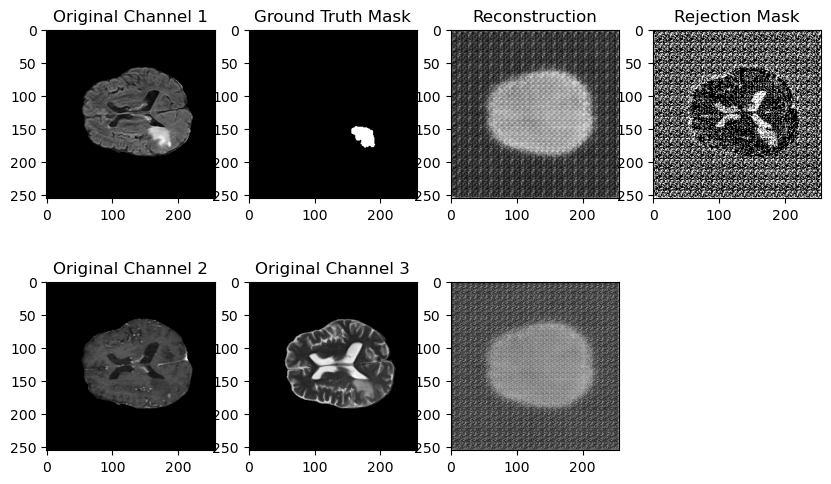

In [10]:
checkpoint_path_idx = 0
test_data_loader = load_dataset(data_dir, BraTS2020Dataset, train=False, healthy=False, batch_size=1, shuffle=True)
sample = next(iter(test_data_loader))
for checkpoint_path_idx in range(NUM_FOLDS):
    checkpoint_path = CHECKPOINT_PATH + f'/fold_{checkpoint_path_idx}/checkpoint.pt'

    # Load the best model
    checkpoint = torch.load(checkpoint_path)
    model = Exp3VariationalAutoEncoder(config).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    ("Model loaded from checkpoint.")

    # Test the model on one picture
    model.eval()
    with torch.no_grad():
        test_data = sample['image'].to(device)
        (q1, q2), mu, logvar = model(test_data)
        # Plot the original image
        plt.figure(figsize=(10, 6))
        plt.subplot(2, 4, 1)
        plt.title("Original Channel 1")
        # show the first channel of the image
        first_channel = test_data.cpu().numpy()[0, 0]
        plt.imshow(first_channel, cmap='gray')
        # Plot the ground truth mask
        plt.subplot(2, 4, 2)
        plt.title("Ground Truth Mask")
        mask = sample['mask'].numpy()[0, 0]
        plt.imshow(mask, cmap='gray')
        # Plot the reconstruction
        plt.subplot(2, 4, 3)
        plt.title("Reconstruction")
        plt.imshow(q2.cpu()[0, 0], cmap='gray')
        # Plot the rejection mask
        plt.subplot(2, 4, 4)
        plt.title("Rejection Mask")
        reject_mask = calculate_rejection_mask(test_data, q2, q2 - q1, (256, 256))[0].squeeze()
        plt.imshow(reject_mask, cmap='gray')
        # Plot the original image
        plt.subplot(2, 4, 5)
        plt.title("Original Channel 2")
        # show the second channel of the image
        second_channel = test_data.cpu().numpy()[0, 1]
        plt.imshow(second_channel, cmap='gray')
        # Plot the original image
        plt.subplot(2, 4, 6)
        plt.title("Original Channel 3")
        # show the third channel of the image
        third_channel = test_data.cpu().numpy()[0, 2]
        plt.imshow(third_channel, cmap='gray')
        # Plot the reconstruction
        plt.subplot(2, 4, 7)
        plt.imshow(q1.cpu()[0, 0], cmap='gray')

        
        